# IS5006 Final Project Backtesting Code

## Date : 10th April, 2022

## Group 03 Algo Trading System

## Authors
Jesper Lim Jun Hao (A0248996B) e0934611@u.nus.edu

Pitchappan Pitchappan Ramaswamy (A0236575W) e0740930@u.nus.edu

Seow Kah Yong (A0032747E) e0383424@u.nus.edu

Zhu Yexin (A0083629W) e0696677@u.nus.edu


# Instructions

Go to the section 'Choose Range for Historical Test From Feb1 - Mar31 2022' to choose a date range (using indexes) from 2 months of historical data. Run all code cells before that cell first.

Once you are happy with the date range, you can run the next cells to simulate our algorithm and learner. The final cells have plots of Profit and Loss, Total Assets, Crypto value and Cash.

The files with results are saved in the local runtime. They can be downloaded and then later uploaded to powerBI to visualize and nalyze the historical run.


# Libraries

In [1]:
import pandas as pd
from threading import *
import datetime
import time
import numpy as np
import operator
import os
from multiprocessing import *

# import alpaca_trade_api as tradeapi

# import spacy
# from spacytextblob.spacytextblob import SpacyTextBlob
# from bs4 import BeautifulSoup

# import rfc3339      # for date object -> date string
# import iso8601      # for date string -> date object

import logging
logging.basicConfig(filename='Log-Info.log', filemode='w', level=logging.INFO)

# Constants

In [2]:
symbol = "BTCUSD"
tick_time = 20
timeframe = "1Min"
exchanges = ["CBSE"]
exchange = "CBSE"
BASE_URL = "https://paper-api.alpaca.markets"
ALPACA_API_KEY = "PKR055KBNBPSHUVPR494"
ALPACA_SECRET_KEY = "tiAVmsA6dEQOOdIfhY4Sun5wJE5PlU960rPMwL0C"
HISTORY_URL = "https://data.alpaca.markets/v1beta1/crypto"

Buy_Sell_Cost_variance = 10

# API

In [3]:
# api = tradeapi.REST(key_id=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, 
#                         base_url=BASE_URL, api_version='v2')

# Data

In [4]:
# df = api.get_crypto_bars("BTCUSD",timeframe="1Min",start="2020-01-01T00:00:00Z",end="2022-01-01T00:00:00Z",exchanges="CBSE").df
# df.to_csv("BTC_ALPACA-2020_2021.csv")
# df.head()

# path = 'BTC_ALPACA-2020_2021.csv'
# df = pd.read_csv(path)
# df.shape

## Quant Agents

In [5]:
def EMA(df):
    df1 = df.copy()
        
    df1['EMA_20'] = df['close'].ewm(span=20, adjust = False).mean()
    df1['EMA_50'] = df['close'].ewm(span=50, adjust = False).mean()
    df1['signal'] = 0.0
    df1['signal'] = np.where(df1['EMA_20'] > df1['EMA_50'], 1.0, 0.0)
    df['EMA'] = df1['signal'].diff()   
    df.fillna(0, inplace=True)

    return df

def SMA(df):
    df1 = df.copy()
        
    df1['SMA_20'] = df['close'].rolling(window=20).mean()
    df1['SMA_50'] = df['close'].rolling(window=50).mean()
    df1['signal'] = 0.0
    df1['signal'] = np.where(df1['SMA_20'] > df1['SMA_50'], 1.0, 0.0)
    df['SMA'] = df1['signal'].diff()   
    df.fillna(0, inplace=True)

    return df

def BB(dfo):

    df = dfo.copy()

    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['STD_DEV_20'] = df['close'].rolling(window=20).std()
    df['BB_Low_20'] = df['SMA_20'] - df['STD_DEV_20'] * 2
    df['BB_High_20'] = df['SMA_20'] + df['STD_DEV_20'] * 2
        
    df['cross_high'] = np.where(df['close'] > df['BB_High_20'], 1, 0)
    df['sell'] = df['cross_high'].diff()
        
    df['cross_low'] = np.where(df['close'] < df['BB_Low_20'], 1, 0)
    df['buy'] = df['cross_low'].diff()

    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['STD_DEV_50'] = df['close'].rolling(window=50).std()
    df['BB_Low_50'] = df['SMA_50'] - df['STD_DEV_50'] * 2
    df['BB_High_50'] = df['SMA_50'] + df['STD_DEV_50'] * 2

    df['LowBands'] = abs(df['BB_Low_20'] - df['BB_Low_50'])
    df['HighBands'] = abs(df['BB_High_20'] - df['BB_High_50'])
    df['BBT_val'] = (df['LowBands'] - df['HighBands']) / df['SMA_20']
        
    BB = []
    BBT = []
    last_action = 0
    for i,row in df.iterrows():
    
        if i%100000 == 0:
            print(i," out of ",len(df)," in BB -",i/len(df))

        # BB
        if row['buy'] == -1:
            BB.append(1)
        elif row['sell'] == -1:
            BB.append(-1)
        else:
            BB.append(0)
        
        # BBT
        if (row['BBT_val'] > 0) and (last_action != 1):
            BBT.append(1)
            last_action = 1
        elif (row['BBT_val'] < 0) and (last_action != -1):
            BBT.append(-1)
            last_action = -1
        else:
            BBT.append(0)

    dfo['BB'] = BB
    dfo['BBT'] = BBT
    dfo['BBT_val'] = df['BBT_val'].values
    dfo.fillna(0,inplace=True)
    return dfo


In [6]:
def FBP(df):
    df['FBP'] = 0
    return df

# Get Data and Signals

In [7]:
# url_original =  'https://drive.google.com/file/d/1WVnio2UCyBgX94ACt_NcTJ8OoLCZoALB/view?usp=sharing'
path_original = 'https://raw.githubusercontent.com/Pitch2342/RandomStuffForColab/master/BTC_Signals-FebMar2022.csv'
original  = pd.read_csv(path_original)
original .shape

# original = BB(SMA(EMA(FBP(df))))

(86303, 15)

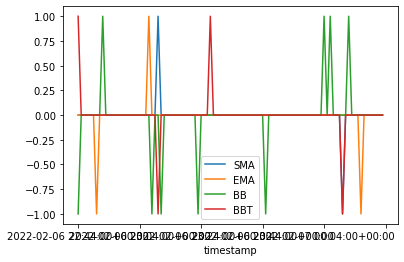

In [8]:
original[10000:10100].plot(x="timestamp", y=["SMA", "EMA", "BB","BBT"])

# Begin main

In [9]:
df = original.copy()
df.head()

,timestamp,exchange,open,high,low,close,volume,trade_count,vwap,FBP,EMA,SMA,BB,BBT,BBT_val
0,2022-01-31 00:00:00+00:00,CBSE,37904.99,37958.49,37904.10,37918.60,9.038193,496,37927.370909,0,0.0,0.0,0,0,0.0
1,2022-01-31 00:01:00+00:00,CBSE,37918.60,37940.07,37915.30,37935.76,10.161914,565,37929.374613,0,1.0,0.0,0,0,0.0
2,2022-01-31 00:02:00+00:00,CBSE,37936.36,37960.18,37905.25,37939.83,12.261485,542,37938.595008,0,0.0,0.0,0,0,0.0
3,2022-01-31 00:03:00+00:00,CBSE,37937.67,37937.68,37900.06,37911.44,6.834917,434,37916.447661,0,0.0,0.0,0,0,0.0
4,2022-01-31 00:04:00+00:00,CBSE,37911.04,37942.04,37888.76,37889.83,11.260317,604,37915.762658,0,-1.0,0.0,0,0,0.0


In [10]:
# GLOBAL VARS
class Wallet():
    def __init__(self):
        self.CRYPTOS = 0.0
        self.CASH = 100000
        self.log = logging.getLogger('Wallet')
        self.log.info("Initialized Wallet")
    def dump(self):
        return self.CASH,self.CRYPTOS

# Orders

In [11]:
class Orders():
    def __init__(self, WALLET):
        self.lock = Lock()
        self.tick_time = tick_time
        self.log = logging.getLogger('Orders')
        self.log.info("Initialized Orders")
        self.WALLET = WALLET

        if (os.path.isfile('Orders.csv')):
            self.orders = pd.read_csv('Orders.csv',index_col=0).to_dict()
            self.log.info("Loading Orders")
        else:
            self.orders = pd.DataFrame(columns = ['Order_ID', 'Client_Order_ID', 'action', 'target_price', 'filled_price', 
                                                  'EMA', 'SMA', 'BB', 'BBT', 'FBP', 'BBT_val',                                                 
                                                  'target_volume', 'filled_volume', 'order_status', 'stop_loss', 'take_profit', 'total_ticks'])
            self.log.info("No Past Orders")   

        if (os.path.isfile('OrderProfitability.csv')):
            self.order_profits = pd.read_csv('OrderProfitability.csv',index_col=0).to_dict()
            self.log.info("Loading Order Profits")
        else:
            self.order_profits = pd.DataFrame(columns = ['Order_ID', 'Client_Order_ID', 'action', 'EMA', 'SMA', 'BB', 'BBT', 
                                                        'FBP', 'BBT_val', 'price', 'total_ticks', 'profit_ticks_5'])
            self.log.info("No Past Order Profits")  
        
        if (os.path.isfile('Wallet.csv')):
            self.wallet = pd.read_csv('Wallet.csv',index_col=0).to_dict()
            self.log.info("Loading Wallet")
        else:
            self.wallet = pd.DataFrame(columns = ['time', 'cash', 'crypto', 
                                                  'crypto_value', 'num_open_orders', 'num_orders', 'total_assets', 'PnL','crypto_price'])
            self.log.info("No Past Wallet")  

        self.order_count = len(self.orders)
        self.order_profits_count = len(self.order_profits)
        self.wallet_count = len(self.wallet)

										
    def tick(self, current):
        self.lock.acquire()
        self.log.info("TICK LOCK ACQUIRED")
        self.log.info("OrderTick")

        self.order_count = len(self.orders)
        self.order_profits_count = len(self.order_profits)
        self.wallet_count = len(self.wallet)

        self.orders = pd.DataFrame(self.orders)
        self.order_profits = pd.DataFrame(self.order_profits)
        self.wallet = pd.DataFrame(self.wallet)


        # self.log.info("Checking StopLoss and TakeProfit")
        # # TakeProfit, StopLoss
        # for i in range(self.order_count):
        #     order_details = self.orders.iloc[i]
        #     current_price = Broker.get_ticker_price()

        #     if order_details['action'] == 'buy':
        #         if order_details['stop_loss'] >= current_price:
        #             self.log.info("STOP LOSS FOUND")
        #             Broker.cancel_order(order_details['Order_ID'])
        #             # Market Sell. No records in tradebook needed. will reflect in wallet.
        #             Broker.place_market_sell_order(symbol, order_details['filled_volume'], str(time.time()))
        #         if order_details['take_profit'] <= current_price:
        #             Broker.cancel_order(order_details['Order_ID'])
        #             self.log.info("TAKE PROFIT FOUND")
        #             # Market Sell. No records in tradebook needed. will reflect in wallet.
        #             Broker.place_market_sell_order(symbol, order_details['filled_volume'], str(time.time()))
        
        # self.log.info("Cancel Long Orders")
        # # Cancel Orders that are over 100 ticks
        # for i in range(self.order_count):
        #     order_details = self.orders.iloc[i]
        #     if order_details['total_ticks'] > 100 and order_details['order_status'] != 'closed':
        #         self.cancel_order(order_details['Client_Order_ID'])

        self.order_count = len(self.orders)
        self.order_profits_count = len(self.order_profits)
        self.wallet_count = len(self.wallet)

        self.log.info("Update Orders")
        self.log.info(len(self.orders))
        # self.log.info(self.orders)
        # Update Orders
        for i in range(len(self.orders)):
#             self.log.info(("updating ",i))
            
            self.orders.at[i,'total_ticks'] = self.orders.at[i,'total_ticks'] + 1
            order_details = self.orders.iloc[i]
            # self.log.info("checking status")
            # if order_details['order_status'] != 'closed':
            #     self.log.info('updating open order')
            #     status = Broker.get_order_status(order_details['Client_Order_ID'])
            #     self.log.info("got status of open order")
            #     self.orders.at[i,'filled_price'] = status.filled_avg_price
            #     self.orders.at[i,'filled_volume'] = status.filled_qty
                
            #     if float(status.filled_qty) == order_details['target_volume']:
            #         self.log.info("CLosing order as filled")
            #         self.orders.at[i,'order_status'] = 'closed'    
            #     elif float(status.filled_qty) > 0:
            #         self.log.info("Partial Fill Order found")
            #         self.orders.at[i,'order_status'] = 'partial'
            #     else:
            #          self.orders.at[i,'order_status'] = 'empty'
                    
            #     if status.canceled_at is not None:
            #         self.orders.at[i,'order_status'] = 'closed'

#         self.log.info("Update Order Profitability")
#         self.log.info(len(self.order_profits))
        # Update existing tickers
        self.log.info("BEGIN TICK UPDATE")
        for i in range(len(self.order_profits)):
            # self.log.info("START TICK UPDATE")
            # self.log.info(("updating ticks for ",i+1,"out of ",len(self.order_profits)))
            self.order_profits.at[i,'total_ticks'] = self.order_profits.at[i,'total_ticks'] + 1

            if self.order_profits.at[i,'action'] == 'buy':
                if self.order_profits.at[i,'total_ticks'] <= 50:
                    price = current['close']
                    # self.log.info([float(price), float(self.order_profits.at[i,'price'])])
                    # print("CUR PRICE : ",float(price))
                    # print("BUY PRICE WAS : ",float(self.order_profits.at[i,'price']))
                    # if (float(price) >= float(self.order_profits.at[i,'price'])):
                    if current['BBT_val'] > float(self.order_profits.at[i,'BBT_val']):
                        # print(i,"BUY PROFIT TICK",float(price), float(self.order_profits.at[i,'price']))
                        self.order_profits.at[i,'profit_ticks_5'] = self.order_profits.at[i,'profit_ticks_5'] + 1
                    # elif float(price) < float(self.order_profits.at[i,'price']) and ( abs(float(price) - float(self.order_profits.at[i,'price'])) > 100 ):
                    elif current['BBT_val'] < 0:
                        # print(i,"BUY LOSS TICK",float(price), float(self.order_profits.at[i,'price']))
                        self.order_profits.at[i,'profit_ticks_5'] = self.order_profits.at[i,'profit_ticks_5'] - 1

            elif self.order_profits.at[i,'action'] == 'sell':
                if self.order_profits.at[i,'total_ticks'] <= 50:
                    price = current['close']
                    # self.log.info([float(price), float(self.order_profits.at[i,'price'])])
                    # print("CUR PRICE : ",float(price))
                    # print("SELL PRICE WAS : ",float(self.order_profits.at[i,'price']))
                    # if float(price) <= float(self.order_profits.at[i,'price']):
                    if current['BBT_val'] < float(self.order_profits.at[i,'BBT_val']):
                        # print(i,"SELL PROFIT TICK",float(price), float(self.order_profits.at[i,'price']))
                        self.order_profits.at[i,'profit_ticks_5'] = self.order_profits.at[i,'profit_ticks_5'] + 1
                    # elif float(price) > float(self.order_profits.at[i,'price']) and ( abs(float(price) - float(self.order_profits.at[i,'price'])) > 100 ):
                    elif current['BBT_val'] > 0:
                        self.order_profits.at[i,'profit_ticks_5'] = self.order_profits.at[i,'profit_ticks_5'] - 1
                        # print(i,"SELL LOSS TICK",float(price), float(self.order_profits.at[i,'price']))

            elif self.order_profits.at[i,'action'] == 'hold':
                if self.order_profits.at[i,'total_ticks'] <= 50:
                    self.order_profits.at[i,'profit_ticks_5'] = self.order_profits.at[i,'profit_ticks_5'] + 0

        # T1 = Buy
        # T2-T6. (Number of times price > buyprice)-(Number of times price < buyprice)
#         self.log.info("Add new closed trades to analysis")
        # get list of all closed order ids and add them
        closed_order_ids = list(self.orders.loc[self.orders['order_status'] == "closed"]['Order_ID'])
        recorded_order_ids = list(self.order_profits['Order_ID'])
        to_add_order_ids = list(set(closed_order_ids) - set(recorded_order_ids))
        for order_to_add in to_add_order_ids:
            self.log.info("ADDING ORDER TO PROFIT ANALYSIS")
            self.log.info(order_to_add)
            row = list(self.orders.loc[self.orders['Order_ID'] == order_to_add][['Order_ID', 'Client_Order_ID', 'action', 'EMA', 'SMA', 'BB', 'BBT', 
                                                        'FBP', 'BBT_val', 'filled_price']].values[0])
            
            row.append(0) # pnl
            row.append(0) # ticks
            
#             self.log.info("Order Profits updated")
            self.order_profits.loc[len(self.order_profits)] = row
            # print("ORDER PROFIT UDATE TYPE ",type(self.order_profits),self.order_profits)
        
#         self.log.info("Wallet Update")
        # Add Wallet Line
        time = current['timestamp']
        self.log.info(time)

        cash = self.WALLET.CASH
#         self.log.info("Find Cryptos")
        crypto = self.WALLET.CRYPTOS
        # print("CRYPTO",crypto)
#         self.log.info("Find Ticker")
        crypto_price = current['close']
        crypto_val = self.WALLET.CRYPTOS * crypto_price
        total_assets = cash + crypto_val
#         self.log.info("Find Open Orders from Broker")
        num_open_orders = 0
#         self.log.info("Find All Orders from Broker")
        num_orders = len(self.orders)
#         self.log.info("Wallet Details ready")
        pnl = total_assets - 100000
#         self.log.info("Adding entry to wallet")
        self.log.info(([time,cash,crypto,crypto_val,num_open_orders,num_orders,total_assets,pnl,crypto_price]))
        self.wallet.loc[len(self.wallet)] = [time,cash,crypto,crypto_val,num_open_orders,num_orders,total_assets,pnl,crypto_price]
        # print("===")
        # print([time,cash,crypto,crypto_val,num_open_orders,num_orders,total_assets,pnl,crypto_price])
        # print(self.wallet)
        # print("---")

        
        # self.log(('wallet entry',[time,cash,crypto,crypto_val,num_open_orders,num_orders,total_assets,pnl,crypto_price]))

        # Save Files
        self.log.info("Save Files")
        self.log.info('Saving Orders')
        # self.log.info(self.orders)
        self.orders.to_csv('Orders.csv')
        self.log.info('Saving Order Profits')
        self.order_profits.to_csv('OrderProfitability.csv')
        self.log.info('Saving Wallet')
        self.wallet.to_csv('wallet.csv')

        self.log.info("TICK LOCK RELEASED")
        self.lock.release()
        

    def place_order(self,action, order_type, volume, price, stop_loss, take_profit, EMA, SMA, BB, BBT, FBP, BBT_val):

        self.lock.acquire()
        self.log.info("PLACE ORDER LOCK ACQUIRED")
        # print("PLACING ORDER ",action, order_type, volume, price)
        
        Client_Order_ID = str(time.time())
        action = action
        order_type = order_type
        target_volume = volume
        target_price = price
        stop_loss = stop_loss
        take_profit = take_profit
        EMA = EMA
        SMA = SMA
        BB = BB
        BBT = BBT
        FBP = FBP
        BBT_val = BBT_val

        filled_price = 0
        filled_volume = 0
        total_ticks = 0
        # order_status = 'open'
        order_status = 'closed'

        # Order_ID = 0
        # if order_type == 'limit':
        #     if action == 'buy':
        #         Order_ID = Broker.place_limit_buy_order(symbol, target_volume, target_price, Client_Order_ID)
        #     elif action =='sell':
        #         Order_ID = Broker.place_limit_sell_order(symbol, target_volume, target_price, Client_Order_ID)
        # else:
        #     if action == 'buy':
        #         Order_ID = Broker.place_market_buy_order(symbol, target_volume, Client_Order_ID)
        #     elif action =='sell':
        #         Order_ID = Broker.place_market_sell_order(symbol, target_volume, Client_Order_ID)
                
        # print("PLACING ORDER WITH ",symbol, target_volume, target_price, Client_Order_ID)
        # print("B4 order ",len(self.orders))

        Order_ID = Client_Order_ID
        filled_price = target_price
        filled_volume = target_volume

        self.orders.loc[len(self.orders)] = [Order_ID, Client_Order_ID, action, target_price, filled_price, 
                                             EMA, SMA, BB, BBT, FBP, BBT_val, target_volume, filled_volume, 
                                             order_status, stop_loss, take_profit, total_ticks]

#         self.log.info(["ORDER WALLET UPDATES BEFORE",self.WALLET.CRYPTOS,self.WALLET.CASH])
#         print(["ORDER WALLET UPDATES BEFORE",self.WALLET.CRYPTOS,self.WALLET.CASH])
        if action == 'buy':
#             print("BUY UPDATE")
            self.WALLET.CRYPTOS = self.WALLET.CRYPTOS + filled_volume
            self.WALLET.CASH = self.WALLET.CASH - (filled_price * filled_volume)
        elif action == 'sell':
#             print("SELL UPDATE")
            self.WALLET.CRYPTOS = self.WALLET.CRYPTOS - filled_volume
            self.WALLET.CASH = self.WALLET.CASH + (filled_price * filled_volume)
#         self.log.info(["ORDER WALLET UPDATES AFTER",self.WALLET.CRYPTOS,self.WALLET.CASH])
#         print(["ORDER WALLET UPDATES AFTER",self.WALLET.CRYPTOS,self.WALLET.CASH])

        # print("After order ",len(self.orders))
#         self.log.info("dumping orders")
#         self.log.info(self.orders)
        self.log.info("PLACE ORDER LOCK RELEASED")
        self.lock.release()

    def dump_order_profitability(self):
        return self.order_profits

    def dump_orders(self):
        return self.orders

    def dump_wallet(self):
        return self.wallet

    def __str__(self):
        return 'Orders'

# Knwoledge

In [12]:
class Knowledge():

    def __init__(self):
        self.lock = Lock()
        self.tick_time = tick_time
        self.log = logging.getLogger('Knowledge')
        self.log.info("Initialized Knowledge")

        if (os.path.isfile('AgentWeights.csv')):
            self.agent_weights = pd.read_csv('AgentWeights.csv',index_col=0).to_dict()
            self.log.info("Loading Knowledge of Signals")
        else:
            self.agent_weights = {
                'BB':{1:1,0:1,-1:1}, 
                'BBT':{1:1,0:1,-1:1},
                'EMA':{1:1,0:1,-1:1}, 
                'SMA':{1:1,0:1,-1:1}, 
                'FBP':{1:0,0:0,-1:0} 
                }
            self.log.info("No Knowledge. Setting all to weights to 1")    
            # BB :  Buy = 10, Sell = 1
            # BBT : Buy = -3, Sell = -3
            # Final Weight : 0.1 - 0.05BTC. if its 1-3 - 0.1 BTC. 3-5 - 0.3 BTC. >5 - 0.3 BTC

    def tick(self):
        self.lock.acquire()
        self.log.info("TICK LOCK ACQUIRED")
        self.log.info('Saving Agent Weights')
        if (os.path.isfile('AgentWeights.csv')):
            df_agent_weights = pd.DataFrame.from_dict(self.agent_weights)
            df_agent_weights['action'] = df_agent_weights.index
            df_agent_weights.reset_index(inplace=True, drop=True)
            df_agent_weights.to_csv('AgentWeights.csv')
        else:
            df_agent_weights = pd.DataFrame.from_dict(self.agent_weights)
            df_agent_weights['action'] = df_agent_weights.index
            df_agent_weights.reset_index(inplace=True, drop=True)
            df_agent_weights.to_csv('AgentWeights.csv')
        self.log.info("TICK LOCK RELEASED")
        self.lock.release()

    def signal_importance(self, agent, signal):
        imp = 0
        # if type(list(self.agent_weights[agent].keys())[0]) == int:
        #     imp = self.agent_weights[agent][signal]
        # else:
        #     imp = self.agent_weights[agent][str(signal)]
        imp = self.agent_weights[agent][signal]
        return imp

    def update_signal_weight(self, agent, weight):
        self.lock.acquire()
        self.log.info("UPDATE LOCK ACQUIRED")
        self.agent_weights[agent] = weight
        self.log.info(("Updated weight of",agent,weight))
        self.log.info("UPDATE LOCK RELEASED")
        self.lock.release()

    def dump_agent_weights(self):
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns',None)
#         self.log.info(pd.DataFrame.from_dict(self.agent_weights))
        return pd.DataFrame.from_dict(self.agent_weights)

    def __str__(self):
        return 'Knowledge'

# Learner

In [13]:
class Learner():

    def __init__(self, knowledge, order):
        self.lock = Lock()
        self.log = logging.getLogger('Learner')
        self.log.info("Initialized Learner")
        self.knowledge = knowledge
        self.order = order
										
    def tick(self):
        self.lock.acquire()
        self.log.info('Beginning a learning experience')
        agent_weights = self.knowledge.dump_agent_weights()
        order_profits = self.order.dump_order_profitability()
        order_profits = order_profits.loc[order_profits['total_ticks'] > 5]
        agents = ['SMA','EMA','BB','BBT','FBP']
        for i in agents:
            self.log.info(("LEARNING FOR ",i))
            # self.log.info(order_profits[i])
            good_buy = len(order_profits[(order_profits[i]==1) & (order_profits['profit_ticks_5']>0)])
            # self.log.info(good_buy)
            bad_buy = len(order_profits[(order_profits[i]==1) & (order_profits['profit_ticks_5']<0)])
            # self.log.info(bad_buy)
            diff_buy = good_buy-bad_buy
            buy = len(order_profits[(order_profits[i]==1)]) + 1
            # self.log.info(buy)
            buy_wt = self.knowledge.signal_importance(i, 1)
            # self.log.info(buy_wt)
            new_buy_wt = buy_wt * (1+(diff_buy/buy))
            if abs(new_buy_wt) > 10:
                new_buy_wt = 10 * new_buy_wt / abs(new_buy_wt)
            if abs(new_buy_wt) < 0.01 and abs(new_buy_wt) != 0:
                new_buy_wt = 0.01 * new_buy_wt / abs(new_buy_wt)
            self.log.info(("BUY",i,good_buy,bad_buy,diff_buy))

            good_sell = len(order_profits[(order_profits[i]==-1) & (order_profits['profit_ticks_5']>0)])
            bad_sell = len(order_profits[(order_profits[i]==-1) & (order_profits['profit_ticks_5']<0)])
            diff_sell = good_sell-bad_sell
            sell = len(order_profits[(order_profits[i]==-1)]) + 1
            sell_wt = self.knowledge.signal_importance(i, -1)
            new_sell_wt = sell_wt * (1+(diff_sell/sell))
            if abs(new_sell_wt) > 10:
                new_sell_wt = 10 * new_sell_wt / abs(new_sell_wt)
            if abs(new_sell_wt) < 0.01 and abs(new_sell_wt) != 0:
                new_sell_wt = 0.01 * new_sell_wt / abs(new_sell_wt)
            self.log.info(("SELL",i,good_sell,bad_sell,diff_sell))

            good_hold = len(order_profits[(order_profits[i]==0) & (order_profits['profit_ticks_5']<0)])
            bad_hold = len(order_profits[(order_profits[i]==0) & (order_profits['profit_ticks_5']>0)])
            diff_hold = good_hold-bad_hold
            hold = len(order_profits[(order_profits[i]==0)]) + 1
            hold_wt = self.knowledge.signal_importance(i, 0)
            new_hold_wt = hold_wt * (1+(diff_hold/hold))
            if abs(new_hold_wt) > 10:
                new_hold_wt = 10 * new_hold_wt / abs(new_hold_wt)
            if abs(new_hold_wt) < 0.01 and abs(new_hold_wt)!=0:
                new_hold_wt = 0.01 * new_hold_wt / abs(new_hold_wt)
            self.log.info(("HOLD",i,good_hold,bad_hold,diff_hold))

            new_wt_dict = {-1:new_sell_wt,0:new_hold_wt,1:new_buy_wt}
            self.knowledge.update_signal_weight(i, new_wt_dict)

            self.log.info(("updating weight for ",i,new_wt_dict))
        self.log.info('learning cycle finished')

        self.lock.release()

    def __str__(self):
        return 'Learner'

# Reviewer

In [14]:
class Reviewer():

    def __init__(self, knowledge):
        self.lock = Lock()
        self.log = logging.getLogger('Reviewer')
        self.log.info("Initialized Reviewer")
        self.knowledge = knowledge

    def review(self, entry):
        # Find all 5 signals and knowledge to find action
        # Entry rows = SMA, EMA, BB, BBT, FBP, price

        buy_importance = 0
        sell_importance = 0
        hold_importance = 0

        agent_weights = self.knowledge.dump_agent_weights()
        for i in ['SMA','EMA','BB','BBT','FBP']:
            if entry[i] == 1:
                buy_importance = buy_importance + agent_weights[i][1]
            elif entry[i] == -1:
                sell_importance = sell_importance + agent_weights[i][-1]
            else:
                hold_importance = hold_importance + agent_weights[i][0]
        self.log.info((buy_importance, sell_importance, hold_importance))

        return [buy_importance, sell_importance, hold_importance ]


    def __str__(self):
        return 'Reviewer'

# CEO

In [15]:
class CEO():

    def __init__(self, knowledge, order, reviewer, WALLET):
        self.lock = Lock()
        self.tick_time = tick_time
        self.log = logging.getLogger('CEO')
        self.log.info("Initialized CEO")
        self.knowledge = knowledge
        self.order = order
        self.reviewer = reviewer
        self.risk_level = 1
        self.status = True
        self.WALLET = WALLET
										
    def tick(self, current):
        self.lock.acquire()
        self.log.info("CEO TICK START")
        # CEO STUFF
        # Get signals

        # Use Review to get action
        # use CBR to check if action is good - orders
        
        # Use Risk to check if action is still good
        # Use risk to decide stoploss and takeprofit
        # decide amount

        # do basic checks and place order
        # Send details via visualizer
        # Mark times where profit is good and profit can be taken out
        
        signals = current
        self.log.info("Signals Recieved")
        self.log.info(("SIGNALS ",list(signals[['SMA','EMA','BB','BBT','FBP','BBT_val']])))

        # DECIDER START
        # Review for Buy,Sell,Hold
        [buy,sell,hold] = self.reviewer.review(signals)
        self.log.info(("buy,sell,hold",[buy,sell,hold]))
        risk_level = self.risk_level
        action = 'hold'
        if risk_level == 1 or risk_level == 4:
            if buy >= (sell+hold):
                action = 'buy'
            elif sell >= (buy+hold):
                action = 'sell'
            else:
                action = 'hold'
        elif risk_level == 2 or risk_level == 5:
            if (hold > buy) and (hold > sell):
                action = 'hold'
            elif buy > sell:
                action = 'buy'
            elif sell > buy:
                action = 'sell'
        elif risk_level == 3 or risk_level == 6:
            if buy > sell:
                action = 'buy'
            elif sell > buy:
                action = 'sell'
            else:
                action = 'hold'
        self.log.info(("Risk and Action ",risk_level,action))

        if action == 'hold':
            self.log.info(("HOLD AT ",time.time()))
        else:
            # CBR 
            order_profitability = pd.DataFrame(self.order.order_profits)
            # print(order_profitability)
            temp_df = order_profitability.loc[(order_profitability['SMA']==signals.SMA) & (order_profitability['EMA']==signals.EMA) & 
                            (order_profitability['BB']==signals.BB) & (order_profitability['BBT']==signals.BBT) &
                            (order_profitability['FBP']==signals.FBP)]
            #  
            pos = len(temp_df.loc[temp_df['profit_ticks_5'] > 0]) + 1
            neg = len(temp_df.loc[temp_df['profit_ticks_5'] < 0]) + 1
            neutral = len(temp_df.loc[temp_df['profit_ticks_5'] == 0]) + 1
            CBR_score = (pos-neg)/(pos+neg+neutral)
            self.log.info(("CBR ",CBR_score))
            
            # Trend Analysis
            trend_multiplier = 1
            if action == 'buy':
                if signals['BBT_val'] >= 0.2:
                    trend_multiplier = 2
                elif signals['BBT_val'] >= 0.1:
                    trend_multiplier = 1.5
                elif signals['BBT_val'] > 0:
                    trend_multiplier = 1.1
                elif signals['BBT_val'] == 0:
                    trend_multiplier = 0
                elif signals['BBT_val'] <= -0.2:
                    trend_multiplier = 0.1
                elif signals['BBT_val'] <= -0.1:
                    trend_multiplier = 0.25
                elif signals['BBT_val'] < 0:
                    trend_multiplier = 0.5
            elif action == 'sell':
                if (-1*signals['BBT_val']) >= 0.2:
                    trend_multiplier = 2
                elif (-1*signals['BBT_val']) >= 0.1:
                    trend_multiplier = 1.5
                elif (-1*signals['BBT_val']) > 0:
                    trend_multiplier = 1.1
                elif (-1*signals['BBT_val']) == 0:
                    trend_multiplier = 0
                elif (-1*signals['BBT_val']) <= -0.2:
                    trend_multiplier = 0.1
                elif (-1*signals['BBT_val']) <= -0.1:
                    trend_multiplier = 0.25
                elif (-1*signals['BBT_val']) < 0:
                    trend_multiplier = 0.5
            self.log.info(("trend and multiplier",signals['BBT_val'] ,trend_multiplier))

            order_type = 'limit'
            if risk_level >= 4:
                order_type = 'market'
            self.log.info(("order type ", order_type))

            default_volume = 0.01
            volume = default_volume * (1+CBR_score) * trend_multiplier
            self.log.info(('default_volume ',default_volume))
            self.log.info(("vol ",volume))

            price = current['close']

            if action =='buy':
                price = price + Buy_Sell_Cost_variance
            elif action =='sell':
                price = price - Buy_Sell_Cost_variance

            # StopLoss and takeProfit
            stop_loss = price *0.9
            take_profit = price * 1.05
            self.log.info(("Price, StopLoss, TakeProfit ",price,stop_loss,take_profit))

            SMA = signals.SMA
            EMA = signals.EMA
            BB = signals.BB
            BBT = signals.BBT
            FBP = signals.FBP
            BBT_val = signals.BBT_val

            
            # DECIDER END
            

            if True:
                self.log.info((action, 'limit', volume, price, 
                        stop_loss, take_profit, EMA, SMA, BB, BBT, FBP, BBT_val))
#                 print((action, 'limit', volume, price, 
#                         stop_loss, take_profit, EMA, SMA, BB, BBT, FBP, BBT_val))
                self.log.info("PLACING ORDER")
                
                crypto = self.WALLET.CRYPTOS
                cash = self.WALLET.CASH
                self.log.info([cash,crypto])
                if action == 'buy':
                    if float(cash) >= float(price)*float(volume):
                        self.order.place_order(action = action, order_type = order_type, volume = volume, price = price, 
                        stop_loss = stop_loss, take_profit = take_profit, EMA = EMA, SMA = SMA, BB = BB, BBT = BBT, FBP = FBP, BBT_val = BBT_val)
                    else:
                        self.log.info("NO BALANCE, CAN'T BUY")
                elif action == "sell":
                    if float(crypto) >= float(volume):
                        self.order.place_order(action = action, order_type = order_type, volume = volume, price = price, 
                        stop_loss = stop_loss, take_profit = take_profit, EMA = EMA, SMA = SMA, BB = BB, BBT = BBT, FBP = FBP, BBT_val = BBT_val)
                    else:
                        self.log.info("NO CRYPTO, CAN'T SELL")
        self.log.info("CEO TICK ENDED")
        self.lock.release()

    def change_risk_level(self, new_risk):
        self.lock.acquire()
        self.log.info("changing risk")
        self.log.info(["OLD RISK",self.risk_level])
        self.risk_level = new_risk
        self.log.info(["NEW RISK",self.risk_level])
        self.log.info("changed risk")
        self.lock.release()

    def change_status(self, status):
        self.lock.acquire()
        self.log.info("changing status")
        self.log.info(["OLD status",self.status])
        self.status = status
        self.log.info(["NEW status",self.status])
        self.log.info("changed status")
        self.lock.release()

    def __str__(self):
        return 'CEO'

# Choose Range for Historical Test From Feb1 - Mar31 2022

In [16]:
original.shape

(86303, 15)

In [17]:
# df = original[:10000]
# df = original[10000:20000]
df = original[20000:23000]
df.head(1).timestamp,df.tail(1).timestamp, len(df)

(20000    2022-02-13 21:24:00+00:00
 Name: timestamp, dtype: object, 22999    2022-02-15 23:23:00+00:00
 Name: timestamp, dtype: object, 3000)

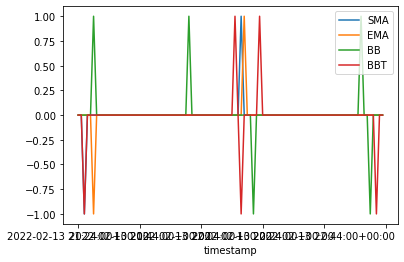

In [18]:
df[:100].plot(x="timestamp", y=["SMA", "EMA", "BB","BBT"])

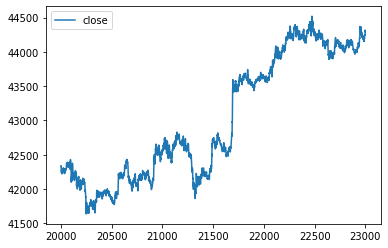

In [19]:
df.plot(y='close')

# Historical Test

In [20]:
Wallet_obj = Wallet()

Orders_obj = Orders(Wallet_obj)###

        # Initialize Signal Weights. Update weights, etc
Knowledge_obj = Knowledge()###

        # Check if trade is possible and decide on stoploss/takeprofit
Reviewer_obj = Reviewer(Knowledge_obj)

        # Periodically, virtually sell all. Then update Knowledge weights
Learner_obj = Learner(Knowledge_obj , Orders_obj)###

        # Use pytrends, twitter, risk values to decide on risk appetite
        # self.RiskAppetite = RiskAppetite()

        # Use signals and weights to decide on action. then use CBR and Risk Appetite to decide volume. 
        # Review trade to see if it is possible and decide on stoploss/takeprofit. Then place limit order. 
CEO_obj = CEO(Knowledge_obj , Orders_obj, Reviewer_obj,Wallet_obj)

In [21]:
start_time = time.time()
for i in range(len(df)):
# for i in range(1000):
    # get signals
    signals = df.iloc[i].copy()
    if i%500== 0:
        print("====")
        print(i)
        print(Wallet_obj.dump())
        print("TIME SO FAR : ",time.time()-start_time)
        try:
            print(np.unique(np.array(pd.read_csv('Orders.csv').action.values),return_counts=True))
            print(pd.read_csv('wallet.csv').tail(1))
        except:
            print("0 orders")
        print("-----\n")

    # CEO
    CEO_obj.tick(signals)

    # Orders
    CEO_obj.order.tick(signals)
    
    if i%120 == 0:
        CEO_obj.knowledge.tick()
        Learner_obj.tick()
    

====
0
(100000, 0.0)
TIME SO FAR :  0.0029113292694091797
0 orders
-----

====
500
(95915.38448, 0.0974)
TIME SO FAR :  10.295889377593994
(array(['buy', 'sell'], dtype=object), array([9, 1]))
     Unnamed: 0                       time         cash  crypto  crypto_value  \
499         499  2022-02-14 05:43:00+00:00  95915.38448  0.0974   4077.739634   

     num_open_orders  num_orders  total_assets       PnL  crypto_price  
499                0          10  99993.124114 -6.875886      41865.91  
-----

====
1000
(88655.72460130216, 0.26959232295482294)
TIME SO FAR :  33.18756079673767
(array(['buy', 'sell'], dtype=object), array([47, 24]))
     Unnamed: 0                       time          cash    crypto  \
999         999  2022-02-14 14:03:00+00:00  88655.724601  0.269592   

     crypto_value  num_open_orders  num_orders   total_assets         PnL  \
999  11467.370961                0          71  100123.095563  123.095563   

     crypto_price  
999      42535.97  
-----

====
150

In [22]:
Knowledge_obj.agent_weights

{'BB': {-1: 0.4996144964929197, 0: 0.01, 1: 0.5781076814832063},
 'BBT': {-1: 10.0, 0: 0.04837215762230567, 1: 10.0},
 'EMA': {-1: 9.999999999999998, 0: 0.013201130899656653, 1: 10.0},
 'FBP': {-1: 0.0, 0: 0.0, 1: 0.0},
 'SMA': {-1: 0.01, 0: 0.01, 1: 10.0}}

In [23]:
Wallet_obj.dump()

(86442.96536798599, 0.32132271170853904)

In [24]:
list(Knowledge_obj.agent_weights.items())

[('BB', {-1: 0.4996144964929197, 0: 0.01, 1: 0.5781076814832063}),
 ('BBT', {-1: 10.0, 0: 0.04837215762230567, 1: 10.0}),
 ('EMA', {-1: 9.999999999999998, 0: 0.013201130899656653, 1: 10.0}),
 ('SMA', {-1: 0.01, 0: 0.01, 1: 10.0}),
 ('FBP', {-1: 0.0, 0: 0.0, 1: 0.0})]

In [25]:
w = pd.read_csv('wallet.csv')
w.shape

(3000, 10)

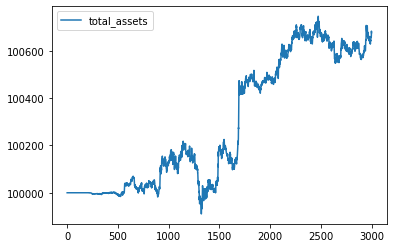

In [26]:
w.plot(y='total_assets')

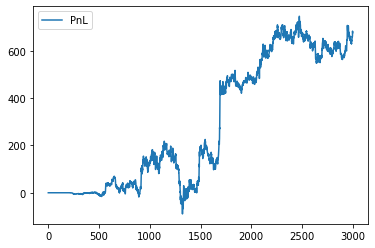

In [27]:
w.plot(y='PnL')

In [28]:
o = pd.read_csv('Orders.csv')
len(o)

325

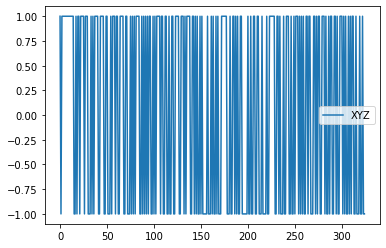

In [29]:
o['XYZ'] = -1
o.loc[o.action == 'buy','XYZ'] = 1
o.plot(y='XYZ')

In [30]:
np.unique(np.array(o.action.values),return_counts=True)

(array(['buy', 'sell'], dtype=object), array([170, 155]))

# Conclusion
Not all ranges generate a profit. And different ranges profuce different agent weights at the end. 

We try to simulate Market Buy/Sell using Buy_Sell_Cost_variance in Constants at 100. To look at a more ideal scenario where we can buy and sell at the exact price we want to, set this to 0 and rerun.

You can also twek CEO risk level in the init section of class CEO to see how model performs under different risk conditions

It is quite surprising though taht multiple experiments generate a profit even after this huge price difference of 100 while buying and selling

Do factory reset the runtime after every run for a smooth run. Sometimes, few bugs exist when reloading previous data.

# Contact Us

If something is still confusing with the code, it crashes, or you wanna just chat. feel free to email any of the authors